In [45]:
import h5py
import matplotlib.pyplot as plt
import tomopy

##inputs
# Path to the data folder
proj_file = '/home/ravescovi/Downloads/NSLS2/scan_00244/proj_00000.hdf'
flat_file = '/home/ravescovi/Downloads/NSLS2/scan_00245/flat_00000.hdf'
dark_file = '/home/ravescovi/Downloads/NSLS2/scan_00245/dark_00000.hdf'
angles_file = '/home/ravescovi/Downloads/NSLS2/scan_00244/scan_00244.nxs'

#recon size
recon_init = 1000
recon_end = recon_init + 100
##

def load_data():
    pass

def recon_data():
    pass

proj = h5py.File(proj_file, 'r')['entry']['data']['data'][:,recon_init:recon_end,:]
print('proj', proj.shape, proj.dtype)

flats = h5py.File(flat_file, 'r')['entry']['data']['data'][:,recon_init:recon_end,:]
print('flats',flats.shape, flats.dtype)

darks = h5py.File(dark_file, 'r')['entry']['data']['data'][:,recon_init:recon_end,:]
print('darks',darks.shape, darks.dtype)

theta = h5py.File(angles_file, 'r')['entry']['data']['rotation_angle'][:]
print('theta',theta.shape, theta.dtype)

# Set data collection angles as equally spaced between 0-180 degrees.
proj_norm = tomopy.normalize(proj, flats, darks)
print('proj_norm', proj_norm.shape, proj_norm.dtype)

# Set data collection angles as equally spaced between 0-180 degrees.
#rot_center = tomopy.find_center_vo(proj_norm)
rot_center = 1609.25 #center of rotation on the full image
print('rot_center',rot_center)

## log normalization
proj_norm_ml = tomopy.minus_log(proj_norm)
print('proj_norm_ml',proj_norm_ml.shape, proj_norm_ml.dtype)

tomo = tomopy.recon(proj_norm_ml, theta, center=rot_center, algorithm='gridrec')
print('tomo',tomo.shape)

proj (1801, 100, 3200) uint16
flats (50, 100, 3200) uint16
darks (20, 100, 3200) uint16
theta (1801,) float32
proj_norm (1801, 100, 3200) float32
rot_center 1609.5
proj_norm_ml (1801, 100, 3200) float32
tomo (100, 3200, 3200)


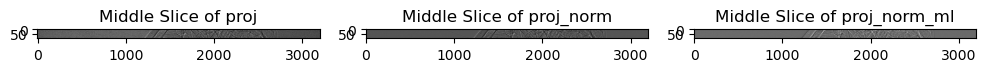

In [51]:
# Plot proj, proj_norm, proj_norm_ml
fig, axes = plt.subplots(1, 3, figsize=(10, 15))

# Plot the middle slice of proj
axes[0].imshow(proj[proj.shape[0] // 2, :, :], cmap='gray')
axes[0].set_title('Middle Slice of proj')

# Plot the middle slice of proj_norm
axes[1].imshow(proj_norm[proj_norm.shape[0] // 2, :, :], cmap='gray')
axes[1].set_title('Middle Slice of proj_norm')

# Plot the middle slice of proj_norm_ml
axes[2].imshow(proj_norm_ml[proj_norm_ml.shape[0] // 2, :, :], cmap='gray')
axes[2].set_title('Middle Slice of proj_norm_ml')

plt.tight_layout()
plt.show()

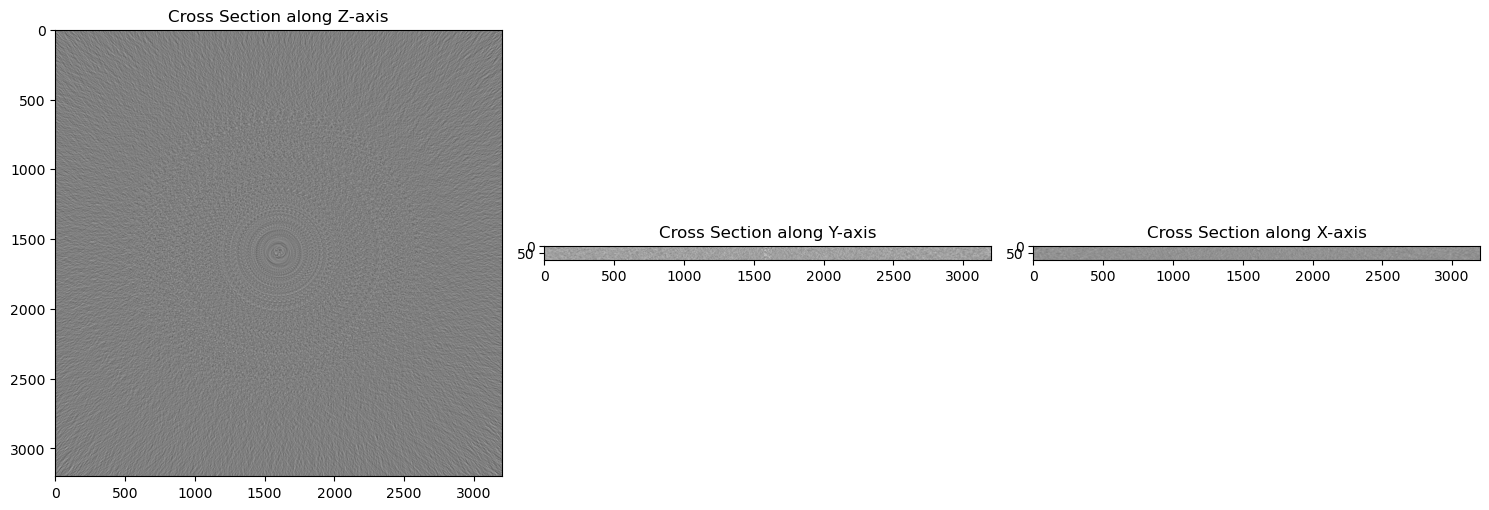

In [50]:
# Plot cross sections of tomo
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the middle slice in each dimension
axes[0].imshow(tomo[tomo.shape[0] // 2, :, :], cmap='gray')
axes[0].set_title('Cross Section along Z-axis')

axes[1].imshow(tomo[:, tomo.shape[1] // 2, :], cmap='gray')
axes[1].set_title('Cross Section along Y-axis')

axes[2].imshow(tomo[:, :, tomo.shape[2] // 2], cmap='gray')
axes[2].set_title('Cross Section along X-axis')

plt.tight_layout()
plt.show()